# About

This program downloads, manages, and exports to .csv files inflation forecast data from the Federal Reserve Bank of Philadelphia, and actual inflation and interest rate data from FRED. The purpose is to learn about historical *ex ante* real interest rates in the US.

In [1]:
import numpy as np
import pandas as pd
import fredpy as fp
import requests
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

# Import forecast data

In [2]:
url = "https://www.philadelphiafed.org/-/media/research-and-data/real-time-center/survey-of-professional-forecasters/historical-data/inflation.xls?la=en"
r = requests.get(url,verify=False)
with open("../xls/inflationForecasts", "wb") as code:
    code.write(r.content)
    
url = "https://www.philadelphiafed.org/-/media/research-and-data/real-time-center/survey-of-professional-forecasters/historical-data/medianlevel.xls?la=en"
r = requests.get(url,verify=False)
with open("../xls/medianLevel.xls", "wb") as code:
    code.write(r.content)

/Users/bcjenkin/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/Users/bcjenkin/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


In [9]:
inflation_forecasts = pd.read_excel('../xls/inflationForecasts.xls')
inflation_forecasts=inflation_forecasts.interpolate()

In [10]:
deflator_forecasts = pd.read_excel('../xls/medianLevel.xls',sheet_name = 'PGDP')
deflator_forecasts=deflator_forecasts.interpolate()
deflator_forecasts = deflator_forecasts.iloc[5:]

In [11]:
cpi_forecasts = pd.read_excel('../xls/medianLevel.xls',sheet_name = 'CPI')
cpi_forecasts = cpi_forecasts.iloc[5:]
cpi_forecasts=cpi_forecasts.interpolate()

## GDP deflator inflation forecasts

In [12]:
# Initialize forecast lists
forecast_1q = []
forecast_2q = []
forecast_1y = []

# Associate forecasts with dates. The date should coincide with the start of the period for which the forecast applies.
dates = []
for i,ind in enumerate(deflator_forecasts.index):
    year =int(deflator_forecasts.iloc[i]['YEAR'])
    quart=int(deflator_forecasts.iloc[i]['QUARTER'])
    if quart == 1:
        month = '01'
    elif quart == 2:
        month = '04'
    elif quart == 3:
        month = '07'
    else:
        month = '10'
        year=year
    date = month+'-01-'+str(year)
    dates.append(date)
    
    forecast_1q.append(400*(deflator_forecasts.iloc[i]['PGDP3']/deflator_forecasts.iloc[i]['PGDP2']-1))
    forecast_2q.append(200*(deflator_forecasts.iloc[i]['PGDP4']/deflator_forecasts.iloc[i]['PGDP2']-1))
    forecast_1y.append(100*(deflator_forecasts.iloc[i]['PGDP6']/deflator_forecasts.iloc[i]['PGDP2']-1))

# Create FRED instances

defl_forecast_1q = fp.to_fred_series(data = forecast_1q,dates = dates,frequency='Quarterly')
defl_forecast_2q = fp.to_fred_series(data = forecast_2q,dates = dates,frequency='Quarterly')
defl_forecast_1y = fp.to_fred_series(data = forecast_1y,dates = dates,frequency='Quarterly')

deflator_frame = pd.DataFrame({'deflator inflation - 3mo forecast':defl_forecast_1q.data,
                          'deflator inflation - 6mo forecast':defl_forecast_2q.data,
                          'deflator inflation - 1yr forecast':defl_forecast_1y.data})

## CPI inflation forecasts

In [13]:
# Initialize forecast lists
forecast_1q = []
forecast_2q = []
forecast_1y = []

# Associate forecasts with dates. The date should coincide with the start of the period for which the forecast applies.
dates = []
for i,ind in enumerate(cpi_forecasts.index):
    year =int(cpi_forecasts.iloc[i]['YEAR'])
    quart=int(cpi_forecasts.iloc[i]['QUARTER'])
    if quart == 1:
        month = '01'
    elif quart == 2:
        month = '04'
    elif quart == 3:
        month = '07'
    else:
        month = '10'
        year=year
    date = month+'-01-'+str(year)
    dates.append(date)
    
    forecast_1q.append(cpi_forecasts.iloc[i]['CPI3'])
    forecast_2q.append(100*(((1 + cpi_forecasts.iloc[i]['CPI3']/100)*(1 + cpi_forecasts.iloc[i]['CPI4']/100))**(1/2)-1))
    forecast_1y.append(100*(((1 + cpi_forecasts.iloc[i]['CPI3']/100)*(1 + cpi_forecasts.iloc[i]['CPI4']/100)*(1 + cpi_forecasts.iloc[i]['CPI5']/100)*(1 + cpi_forecasts.iloc[i]['CPI6']/100))**(1/4)-1))
    

# Create FRED instances

cpi_forecast_1q = fp.to_fred_series(data = forecast_1q,dates=dates)
cpi_forecast_2q = fp.to_fred_series(data = forecast_2q,dates=dates)
cpi_forecast_1y = fp.to_fred_series(data = forecast_1y,dates=dates)


cpi_frame = pd.DataFrame({'cpi inflation - 3mo forecast':cpi_forecast_1q.data,
                          'cpi inflation - 6mo forecast':cpi_forecast_2q.data,
                          'cpi inflation - 1yr forecast':cpi_forecast_1y.data,})

In [14]:
fr = pd.concat([cpi_frame,deflator_frame],axis=1)

## Long-run CPI and gdp deflator forecasts

In [15]:
cpiForecast_10y = []

# 3.3 Associate forecasts with dates. The date should coincide with the start of the period for which the forecast applies.
dates = []
for i,ind in enumerate(inflation_forecasts.index):
    year =int(inflation_forecasts.iloc[i]['YEAR'])
    quart=int(inflation_forecasts.iloc[i]['QUARTER'])
    if quart == 1:
        month = '01'
    elif quart == 2:
        month = '04'
    elif quart == 3:
        month = '07'
    else:
        month = '10'
        year=year
    date = month+'-01-'+str(year)
    dates.append(date)
    
    cpiForecast_10y.append(inflation_forecasts.iloc[i]['INFCPI10YR'])

# # 3.4 Create the FRED instances
cpi_forecast_10y = fp.to_fred_series(data= cpiForecast_10y,dates=dates)
long_run_frame = pd.DataFrame({'cpi inflation - 10yr forecast':cpi_forecast_10y.data})

In [16]:
fr = pd.concat([cpi_frame,deflator_frame,long_run_frame],axis=1)

/Users/bcjenkin/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


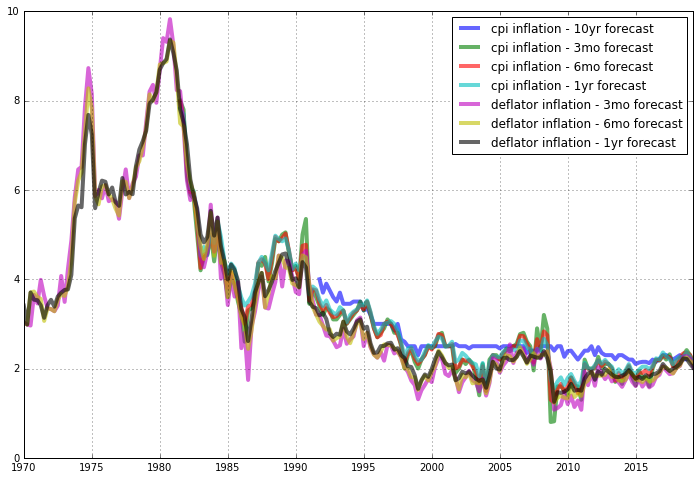

In [17]:
inflation_forecasts_frame = pd.concat([long_run_frame,cpi_frame,deflator_frame],axis=1)

fig = plt.figure(figsize = (12,8))
for c in inflation_forecasts_frame.columns:
    plt.plot_date(inflation_forecasts_frame.index,inflation_forecasts_frame[c],'-',lw=4,alpha = 0.6)
    
plt.legend()
plt.grid()

## Actual data

In [18]:
interest3mo = fp.series('TB3MS').as_frequency('Q')
interest6mo = fp.series('TB6MS').as_frequency('Q')
interest1yr = fp.series('GS1').as_frequency('Q')
interest10yr= fp.series('GS10').as_frequency('Q')

interest3mo,interest6mo,interest1yr,interest10yr = fp.window_equalize([interest3mo,interest6mo,interest1yr,interest10yr])

interest_frame = pd.DataFrame({'interest 3mo':interest3mo.data,
                             'interest 6mo':interest6mo.data,
                             'interest 1yr':interest1yr.data,
                             'interest 10yr':interest10yr.data})

In [19]:
fr = pd.concat([inflation_forecasts_frame,interest_frame],axis=1)

In [20]:
defl_3mo = fp.series('GDPDEF')
defl_6mo = fp.series('GDPDEF')
defl_1yr = fp.series('GDPDEF')

defl_3mo.pc(method='forward',annualized=True)

defl_6mo.data = (defl_6mo.data.shift(-2)/defl_6mo.data-1)*200
defl_6mo = defl_6mo.drop_nan()

defl_1yr.data = (defl_1yr.data.shift(-4)/defl_1yr.data-1)*100
defl_1yr = defl_1yr.drop_nan()

defl_3mo_frame = pd.DataFrame({'deflator inflation - 3mo actual':defl_3mo.data})
defl_6mo_frame = pd.DataFrame({'deflator inflation - 6mo actual':defl_6mo.data})
defl_1yr_frame = pd.DataFrame({'deflator inflation - 1yr actual':defl_1yr.data})

In [21]:
fr = pd.concat([fr,defl_1yr_frame],axis=1)

In [22]:
cpi_3mo = fp.series('CPIAUCSL').as_frequency('Q')
cpi_6mo = fp.series('CPIAUCSL').as_frequency('Q')
cpi_1yr = fp.series('CPIAUCSL').as_frequency('Q')
cpi_10yr = fp.series('CPIAUCSL').as_frequency('Q')


cpi_3mo.pc(method='forward',annualized=True)

cpi_6mo.data = (cpi_6mo.data.shift(-2)/cpi_6mo.data-1)*200
cpi_6mo = cpi_6mo.drop_nan()


cpi_1yr.data = (cpi_1yr.data.shift(-4)/cpi_1yr.data-1)*100
cpi_1yr = cpi_1yr.drop_nan()


cpi_10yr.data = ((cpi_10yr.data.shift(-40)/cpi_10yr.data)**(1/40)-1)*400
cpi_10yr = cpi_10yr.drop_nan()


cpi_3mo_frame = pd.DataFrame({'cpi inflation - 3mo actual':cpi_3mo.data})

cpi_6mo_frame = pd.DataFrame({'cpi inflation - 6mo actual':cpi_6mo.data})

cpi_1yr_frame = pd.DataFrame({'cpi inflation - 1yr actual':cpi_1yr.data})

cpi_10yr_frame = pd.DataFrame({'cpi inflation - 10yr actual':cpi_10yr.data})

In [23]:
fr = pd.concat([fr,cpi_3mo_frame,cpi_6mo_frame,cpi_1yr_frame,cpi_10yr_frame],axis=1)

In [24]:
actual_rates_frame = pd.concat([interest_frame,defl_3mo_frame,defl_6mo_frame,defl_1yr_frame,cpi_3mo_frame,
                                cpi_6mo_frame,cpi_1yr_frame,cpi_10yr_frame],axis = 1)

In [25]:
full_data_frame = pd.concat([actual_rates_frame,inflation_forecasts_frame],axis=1)

In [26]:
full_data_frame.columns
full_data_frame[[
        'interest 3mo', 'interest 6mo', 'interest 1yr', 'interest 10yr',
       'deflator inflation - 3mo actual', 'deflator inflation - 6mo actual',
       'deflator inflation - 1yr actual', 'cpi inflation - 3mo actual',
       'cpi inflation - 6mo actual', 'cpi inflation - 1yr actual','cpi inflation - 10yr actual',
       'cpi inflation - 1yr forecast', 'cpi inflation - 3mo forecast',
       'cpi inflation - 6mo forecast', 'deflator inflation - 1yr forecast','cpi inflation - 10yr forecast',
       'deflator inflation - 3mo forecast','deflator inflation - 6mo forecast']].to_csv('../csv/inflationForecastData.csv')

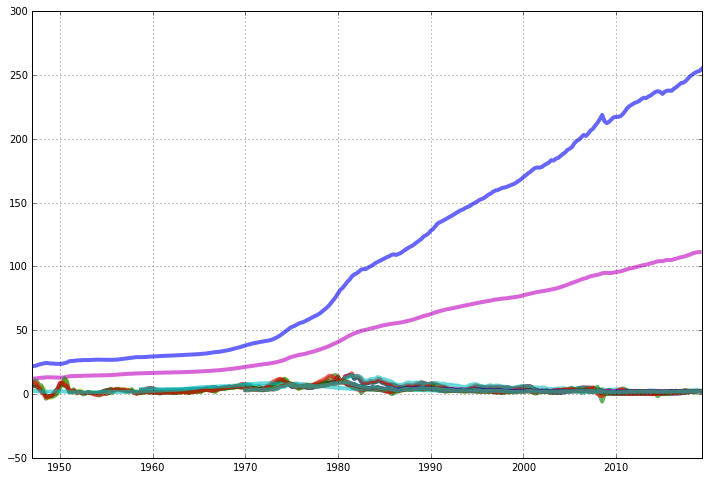

In [27]:
fig = plt.figure(figsize = (12,8))
for c in full_data_frame.columns:
    plt.plot_date(full_data_frame.index,full_data_frame[c],'-',lw=4,alpha = 0.6)
    
plt.grid()

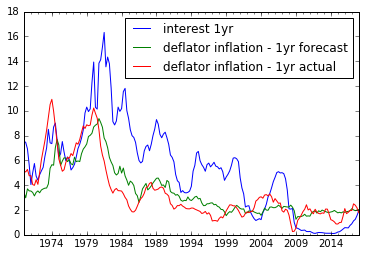

In [28]:
full_data_frame[['interest 1yr','deflator inflation - 1yr forecast','deflator inflation - 1yr actual']].dropna().plot()
# full_data_frame[].dropna().plot()

In [29]:
data_frame = full_data_frame[['deflator inflation - 1yr forecast','deflator inflation - 1yr actual','interest 1yr'   ]]
data_frame = data_frame.dropna(subset = ['deflator inflation - 1yr forecast','interest 1yr'])
# data_frame = data_frame.resample('A', how='mean',convention='start',kind='timestamp')

r = data_frame['interest 1yr'] - full_data_frame['deflator inflation - 1yr forecast']
pie = data_frame['deflator inflation - 1yr forecast']
pi = data_frame['deflator inflation - 1yr actual']
i = data_frame['interest 1yr']

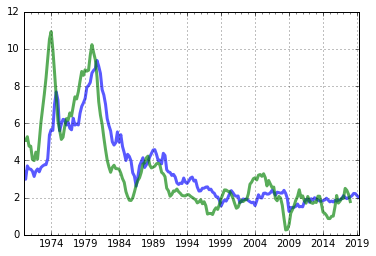

In [30]:
pie.plot(lw=3,alpha =.65)
pi.plot(lw=3,alpha =.65)
plt.grid()